In [1]:
import datetime
from nowtrade.symbol_list import SymbolList
from nowtrade.data_connection import MongoDatabaseConnection
from nowtrade.data_connection import YahooConnection
from nowtrade.dataset import Dataset
from nowtrade.technical_indicator import SMA, EMA, RSI, BBANDS, STOCH, STOCHF 
from nowtrade.criteria import CrossingAbove
from nowtrade.criteria import TrailingStop
from nowtrade.criteria_group import CriteriaGroup
from nowtrade.action import Long
from nowtrade.action import LongExit
from nowtrade.trading_profile import TradingProfile
from nowtrade.trading_amount import StaticAmount
from nowtrade.trading_fee import StaticFee
from nowtrade.strategy import Strategy
from nowtrade import technical_indicator
from nowtrade import criteria
import pandas as pd
import numpy as np

In [2]:
# symbol = 'BHARTIARTL.NS'
# yahoo = YahooConnection()
# symbols=['BHARTIARTL.NS']
# train_start = datetime.datetime(2011, 2, 9)
# train_end = datetime.datetime(2021,2, 9)
# data = yahoo.get_data(symbol, train_start, train_end)
# data.to_csv('{0}{1}_{2}.csv'.format(symbol,train_end.year,train_end.month),index=True,header=True)

In [3]:
# Create our stock list to inform our data connection which stocks to retrieve
stocks = SymbolList(['GOOGL'])
# We can now use this variable to reference our stock when defining enter/exit criteria
googl = stocks.get('GOOGL')
# Specify our start and end dates for this backtest
start = datetime.datetime(2010, 2, 9)
end = datetime.datetime(2021, 2, 9)
# Create the dataset that will hold all of the stock data
dc = YahooConnection()
stock_data = Dataset(stocks, dc, start, end)

In [4]:
stock_data.load_data()

In [6]:
sma50=SMA(googl.close,50)
# 100-day simple moving average of GOOGL close prices
sma100=SMA(googl.close,100)
ema50=EMA(googl.close,50)
stock_data.add_technical_indicator(ema50)

# Now that we've defined our technical indicators, we need to apply them to our dataset
stock_data.add_technical_indicator(sma50)
stock_data.add_technical_indicator(sma100)

In [7]:
bbands50 = BBANDS(googl.close,50)
rsi50=RSI(googl.close,50)
stoch_=STOCH(googl)
stochf_=STOCHF(googl)
# Now that we've defined our technical indicators, we need to apply them to our dataset
stock_data.add_technical_indicator(bbands50)
stock_data.add_technical_indicator(rsi50)
stock_data.add_technical_indicator(stoch_)
stock_data.add_technical_indicator(stochf_)

In [8]:
import pandas as pd

In [9]:
sma1=sma50.value
sma2=sma100.value
bbands=bbands50.value
ema=ema50.value
rsi=rsi50.value
stoch=stoch_.value
stochf=stochf_.value

In [10]:
z=pd.DataFrame(stock_data.data_frame[295:].loc[:,['GOOGL_Close',sma1,sma2,bbands,ema,rsi,stoch,stochf]])

In [11]:
z.columns=['GOOGL_Close','SMA_50','SMA_100','BBANDS','EMA','RSI','STOCH','STOCHF']

In [12]:
z.head()

,GOOGL_Close,SMA_50,SMA_100,BBANDS,EMA,RSI,STOCH,STOCHF
Date,,,,,,,,
2011-04-08,289.369354,298.238639,299.137438,307.676486,295.173435,48.180747,40.091822,42.945598
2011-04-11,288.973969,298.002202,299.105656,307.204144,294.930319,48.035595,50.775107,60.853764
2011-04-12,285.590576,297.704404,299.040891,306.723168,294.564054,46.804356,39.750754,15.452901
2011-04-13,288.428436,297.356456,298.939390,306.234725,294.323442,47.946296,41.726203,48.871944
2011-04-14,289.544556,297.021221,298.877728,305.740286,294.136035,48.390914,42.146365,62.114250


In [13]:
# Criteria
symbol=googl
from nowtrade import criteria_group, strategy, trading_profile, trading_amount, trading_fee
from nowtrade.action import Short, ShortExit
enter_crit_long1 = criteria.Above(rsi50.value, 60)
enter_crit_long3 = criteria.Above(ema50.value, 60)
# SMA100 slope is moving up
enter_crit_long2 = criteria.Above(sma50.value, sma100.value)
enter_crit_short1 = criteria.Below(rsi50.value, 40)
# SMA100 slope is moving down
enter_crit_short2 = criteria.Below(sma50.value, sma100.value)
enter_crit_short3 = criteria.Below(ema50.value, 40)
# Stop loss and take profit exit criteria
exit_crit_long1 = criteria.StopLoss(symbol, 0.01, percent=True) # 1%
exit_crit_long2 = criteria.TakeProfit(symbol, 50) # $100
exit_crit_short1 = criteria.StopLoss(symbol, 0.01, short=True, percent=True) # 1%
exit_crit_short2 = criteria.TakeProfit(symbol, 50, short=True) # $100
# Criteria Groups
enter_crit_group1 = criteria_group.CriteriaGroup([enter_crit_long1, enter_crit_long2, enter_crit_long3], Long(), symbol)
enter_crit_group2 = criteria_group.CriteriaGroup([enter_crit_short1, enter_crit_short2, enter_crit_short3], Short(), symbol)
exit_crit_group1 = criteria_group.CriteriaGroup([exit_crit_long1], LongExit(), symbol)
exit_crit_group2 = criteria_group.CriteriaGroup([exit_crit_long2], LongExit(), symbol)
exit_crit_group3 = criteria_group.CriteriaGroup([exit_crit_short1], ShortExit(), symbol)
exit_crit_group4 = criteria_group.CriteriaGroup([exit_crit_short2], ShortExit(), symbol)

In [14]:
tp = trading_profile.TradingProfile(20000, trading_amount.StaticAmount(10000), trading_fee.StaticFee(5))
strat = strategy.Strategy(stock_data, [enter_crit_group1, enter_crit_group2, exit_crit_group1, exit_crit_group2, exit_crit_group3, exit_crit_group4], tp)
strat.simulate()

In [15]:
print(strat.report.pretty_overview())

ey=9877.782348632812, fee=5, slippage=0.0)
Trade(datetime=2014-01-27 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=563.6135864257812, shares=17, money=9581.430969238281, fee=5, slippage=0.0)
Trade(datetime=2014-01-31 00:00:00, action=LONG, symbol=GOOGL, price=586.2612915039062, shares=17, money=9966.441955566406, fee=5, slippage=0.0)
Trade(datetime=2014-02-03 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=590.190185546875, shares=17, money=10033.233154296875, fee=5, slippage=0.0)
Trade(datetime=2014-02-07 00:00:00, action=LONG, symbol=GOOGL, price=584.3994140625, shares=17, money=9934.7900390625, fee=5, slippage=0.0)
Trade(datetime=2014-02-10 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=586.4865112304688, shares=17, money=9970.270690917969, fee=5, slippage=0.0)
Trade(datetime=2014-02-11 00:00:00, action=LONG, symbol=GOOGL, price=590.6756591796875, shares=17, money=10041.486206054688, fee=5, slippage=0.0)
Trade(datetime=2014-02-12 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=59

In [16]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [17]:
mms=MinMaxScaler()

In [18]:
zy=pd.DataFrame(mms.fit_transform(z))

In [19]:
zy.columns=z.columns

In [20]:
zy=zy.set_index(z.index)

In [21]:
zy.head()

,GOOGL_Close,SMA_50,SMA_100,BBANDS,EMA,RSI,STOCH,STOCHF
Date,,,,,,,,
2011-04-08,0.027924,0.025113,0.021768,0.033935,0.022732,0.351458,0.394516,0.429456
2011-04-11,0.027710,0.024961,0.021746,0.033628,0.022577,0.347166,0.503649,0.608538
2011-04-12,0.025883,0.024769,0.021701,0.033315,0.022342,0.310764,0.391032,0.154529
2011-04-13,0.027416,0.024544,0.021630,0.032997,0.022188,0.344526,0.411212,0.488719
2011-04-14,0.028019,0.024328,0.021587,0.032676,0.022068,0.357672,0.415504,0.621143


In [22]:
%matplotlib inline

<AxesSubplot:xlabel='Date'>

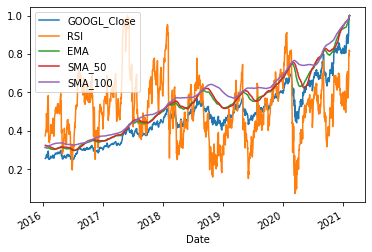

In [23]:
zy[1200:][['GOOGL_Close','RSI','EMA','SMA_50','SMA_100']].plot()

<AxesSubplot:xlabel='Date'>

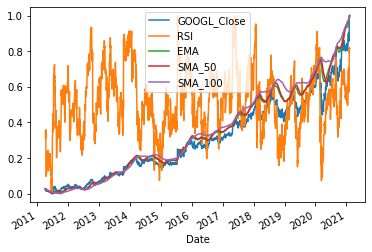

In [24]:
zy[['GOOGL_Close','RSI','EMA','SMA_50','SMA_100']].plot()